In [27]:
%load_ext autoreload
%autoreload 2

from numcosmo_py import Ncm, Nc, GObject

from richness_mass_calib import create_richness_mass_calib
import numpy as np
import math
import sys
import os.path

from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt

# Bibliotecas complementares
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
from sklearn.decomposition import PCA

import numpy as np
from scipy.stats import truncnorm

#Settings
Ncm.cfg_init()

%matplotlib inline
%matplotlib widget
sys.path.insert(0, "/global/homes/c/cinlima/gcr-catalogs")
sys.path.insert(0, "/global/homes/c/cinlima/NumCosmo/notebooks/richness_proxy")

import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")

from matplotlib.widgets import Button, Slider


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# DC2 data
DC2_halos_m200c = fits.open(
    "/global/cfs/projectdirs/lsst/groups/CL/cosmoDC2_v1.1.4/extragal/full/halos/halos_m200c_13.0.fits")

dt_halos = Table(DC2_halos_m200c[1].data)

lnM = np.log(dt_halos["m200c"])  # ln(mass)
z = dt_halos["redshift_true"]  # redshift
lnR = np.log(dt_halos["richness"])  # ln(richness)

In [17]:
rmdata = create_richness_mass_calib(dt_halos)

ascaso = Nc.ClusterMassAscaso()

ascaso.param_set_by_name("mup0", 4.45393539397061)
ascaso.param_set_by_name("mup1", 0.688627943224023)
ascaso.param_set_by_name("mup2", 1.23735536845047)
ascaso.param_set_by_name("sigmap0", 0.227197277810533)
ascaso.param_set_by_name("sigmap1", -0.0514034833229222)
ascaso.param_set_by_name("sigmap2", -0.125446104089159)
ascaso.param_set_by_name("cut", 1e15)


lnrich_ext = Nc.ClusterMassLnrichExt()
lnrich_ext.param_set_by_name("mu", 3.95849990149314)
lnrich_ext.param_set_by_name("muM1", 0.834834799745832)
lnrich_ext.param_set_by_name("muZ1", 0.695004688438083)
lnrich_ext.param_set_by_name("muM2", 0.0421606025663114)
lnrich_ext.param_set_by_name("muZ2", -0.051715032078255)
lnrich_ext.param_set_by_name("muMZ", 0.0402769634041103)
        

lnrich_ext.param_set_by_name("sigma0", 0.306313313048325)
lnrich_ext.param_set_by_name("sigmaM1", 0.00737198200713169)
lnrich_ext.param_set_by_name("sigmaZ1", -0.0212988049057424)
lnrich_ext.param_set_by_name("sigmaM2", 0.015610993686449)
lnrich_ext.param_set_by_name("sigmaZ2", 0.00480098229907118)
lnrich_ext.param_set_by_name("sigmaMZ", 0.0111750633563743)

lnrich_ext.param_set_by_name("cut", 1e15)
lnrich_ext.param_set_by_name("cutM1", 0)
lnrich_ext.param_set_by_name("cutZ1", 0)
   
mset_ext = Ncm.MSet()
mset_ext.set(lnrich_ext)

# lnR mean and std

def compute_res(rich_model):

    lnR_mean = np.array(
        [rich_model.get_mean_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )
    lnR_std = np.array(
        [rich_model.get_std_richness(lnM[i], z[i]) for i in range(len(dt_halos))]
    )

    abs_err = (lnR - lnR_mean) / lnR_std
    # Data cut
    sigma_cut = 5.0

    sigma_cut_array = np.abs(abs_err) < sigma_cut
    print(f"Cutting {sigma_cut}-sigma, {np.sum(np.logical_not(sigma_cut_array))}")

    lnR_mean = lnR_mean[sigma_cut_array]
    z_sigma_cut = z[sigma_cut_array]
    lnM_sigma_cut = lnM[sigma_cut_array]
    abs_err = abs_err[sigma_cut_array]
    
    lnR_std=lnR_std[sigma_cut_array]
    dt_halos_res = dt_halos[sigma_cut_array]
    
    
    return abs_err, lnR_mean, z_sigma_cut, lnM_sigma_cut, lnR_std, dt_halos_res

res_ascaso, lnR_mean_ascaso, z_sigma_cut_ascaso, lnM_sigma_cut_ascaso, lnR_std_ascaso, dt_halos_ascaso = compute_res(ascaso)
res_ext, lnR_mean_ext, z_sigma_cut_ext, lnM_sigma_cut_ext, lnR_std_ext, dt_halos_ext = compute_res(lnrich_ext)


Cutting 5.0-sigma, 95
Cutting 5.0-sigma, 97


In [98]:
MSE = np.square(np.log(dt_halos_ascaso["richness"] - lnR_mean_ascaso)).mean() 

RMSE = math.sqrt(MSE)
print(f"Root Mean Square Error (RMSE):\t{RMSE}\n")

V = np.square(lnR_std_ascaso).mean()
#V = sum(np.square(np.log(dt_halos_ascaso["richness"] - lnR_mean_ascaso))) / (len(lnR_mean_ascaso)-1)
RV = math.sqrt(V)              

print(f"Root Variance:\t{RV}\n")
print(f"Bias:\t{V - MSE}\n")


Root Mean Square Error (RMSE):	2.5442603670383357

Root Variance:	0.35204269590218457

Bias:	-6.349326755543969



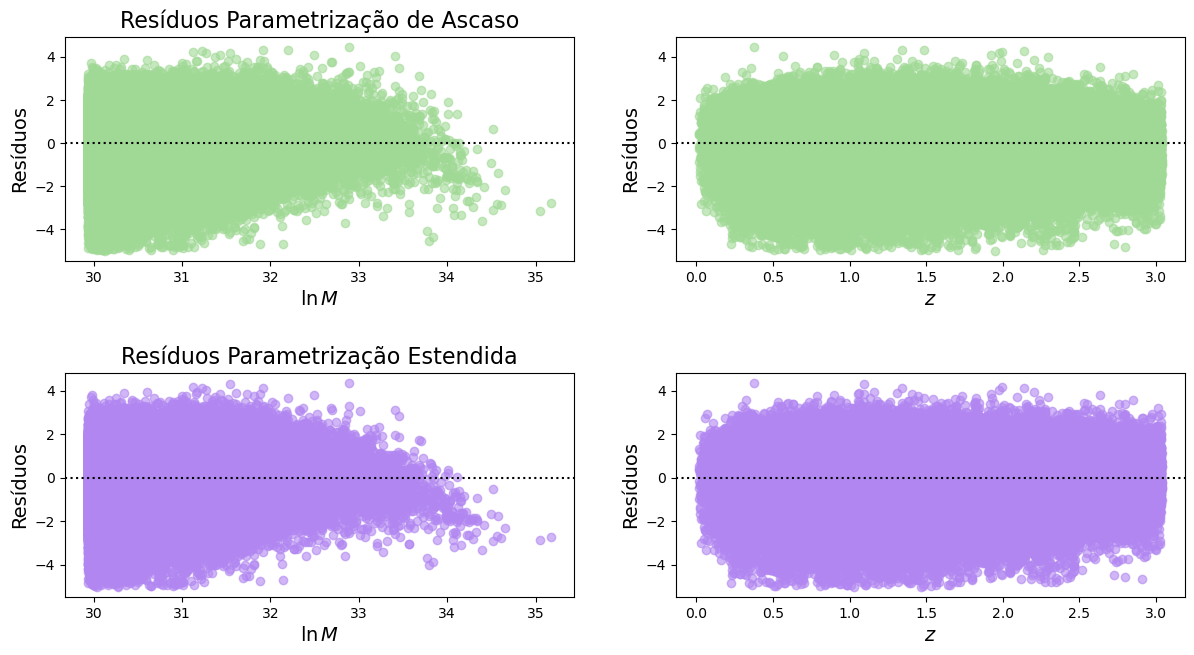

In [4]:
fig = plt.figure(figsize=(14,7))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(lnM_sigma_cut_ascaso, res_ascaso, c="#a0d995", alpha=0.6)
ax1.set_xlabel("$\ln M$", fontsize=14)
ax1.set_ylabel("Resíduos", fontsize=14)
ax1.axhline(y=0.0, color='black', linestyle='dotted')
ax1.set_title("Resíduos Parametrização de Ascaso", fontsize=16)

ax2.scatter(z_sigma_cut_ascaso, res_ascaso,  c="#a0d995", alpha=0.6)
ax2.set_xlabel("$z$", fontsize=14)
ax2.set_ylabel("Resíduos", fontsize=14)
ax2.axhline(y=0.0, color='black', linestyle='dotted')

ax3.scatter(lnM_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax3.set_xlabel("$\ln M$", fontsize=14)
ax3.set_ylabel("Resíduos", fontsize=14)
ax3.set_title("Resíduos Parametrização Estendida", fontsize=16)
ax3.axhline(y=0.0, color='black', linestyle='dotted')

ax4.scatter(z_sigma_cut_ext, res_ext, c="#b186f1", alpha=0.6)
ax4.set_xlabel("$z$", fontsize=14)
ax4.set_ylabel("Resíduos", fontsize=14)
ax4.axhline(y=0.0, color='black', linestyle='dotted')

plt.show()

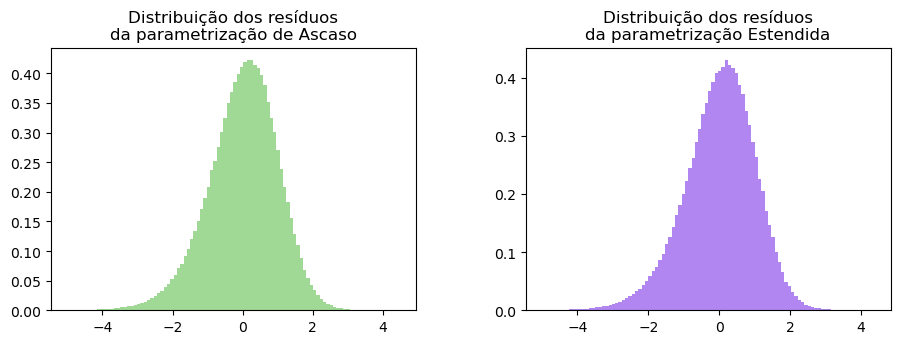

In [5]:
fig = plt.figure(figsize=(12, 9))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.8, 
                    wspace=0.3, 
                    hspace=0.4)

ax1.hist(res_ascaso, bins=100, density=True, color ="#a0d995")
ax1.set_title("Distribuição dos resíduos\nda parametrização de Ascaso")

ax2.hist(res_ext, bins=100, density=True, color="#b186f1")
ax2.set_title("Distribuição dos resíduos\nda parametrização Estendida")

plt.show()

In [6]:
print(stats.kstest(res_ascaso, stats.norm.cdf, args=(np.mean(res_ascaso), np.std(res_ascaso))))
print(stats.kstest(res_ext, stats.norm.cdf, args=(np.mean(res_ext), np.std(res_ext))))

KstestResult(statistic=0.02970281608104719, pvalue=0.0, statistic_location=-0.09012375814704895, statistic_sign=-1)
KstestResult(statistic=0.030650847473451148, pvalue=0.0, statistic_location=-0.19515672332653886, statistic_sign=-1)


In [7]:
def p(model, lnM, z, lnR):
        
    lnR_mean =  model.get_mean_richness(lnM, z)
    lnR_std = model.get_std_richness(lnM, z) 
    
    pdf=[]
    for i in range(len(lnR)):
        x = (lnR[i] - lnR_mean) / lnR_std;
        pdf.append(1.0 / (np.sqrt(2 * np.pi) * lnR_std) * np.exp (-0.5 * x * x))

    return np.array(pdf)


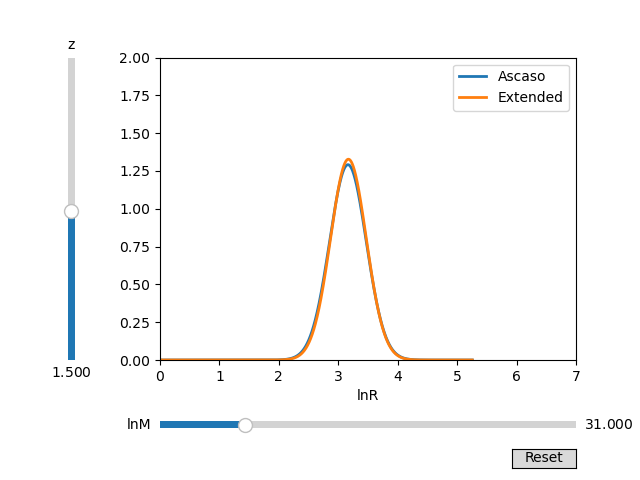

In [48]:
def ascasof(lnR_range, lnmass, redshift):
    return p(ascaso, lnmass, redshift, lnR_range) 

def lnrich_extf(lnR_range, lnmass, redshift):
    return p(lnrich_ext, lnmass, redshift, lnR_range) 


min_lnR = min(lnR)
max_lnR = max(lnR)
lnR_range = np.linspace(min_lnR, max_lnR, 1000)

# Define initial parameters
init_lnmass = 31.0
init_redshift = 1.5

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line1, = ax.plot(lnR_range, ascasof(lnR_range, init_lnmass, init_redshift), lw=2)
line2, = ax.plot(lnR_range, lnrich_extf(lnR_range, init_lnmass, init_redshift), lw=2)
ax.set_xlabel('lnR')
ax.set_xlim(0.0, 7.0)
ax.set_ylim(0.0, 2.0)
line1.set_label('Ascaso')
line2.set_label('Extended')
ax.legend()


# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the lnM.
axlnM = fig.add_axes([0.25, 0.1, 0.65, 0.03])
lnM_slider = Slider(
    ax=axlnM,
    label='lnM',
    valmin=min(lnM),
    valmax=max(lnM),
    valinit=init_lnmass,
)

# Make a vertically oriented slider to control the z
axz = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
z_slider = Slider(
    ax=axz,
    label="z",
    valmin=min(z),
    valmax=max(z),
    valinit=init_redshift,
    orientation="vertical"
)

# The function to be called anytime a slider's value changes
def update1(val):
    line1.set_ydata(ascasof(lnR_range, lnM_slider.val, z_slider.val))
    fig.canvas.draw_idle()

def update2(val):
    line2.set_ydata(lnrich_extf(lnR_range, lnM_slider.val, z_slider.val))
    fig.canvas.draw_idle()

# register the update function with each slider
lnM_slider.on_changed(update1)
lnM_slider.on_changed(update2)
z_slider.on_changed(update1)
z_slider.on_changed(update2)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    lnM_slider.reset()
    z_slider.reset()
button.on_clicked(reset)

plt.show()

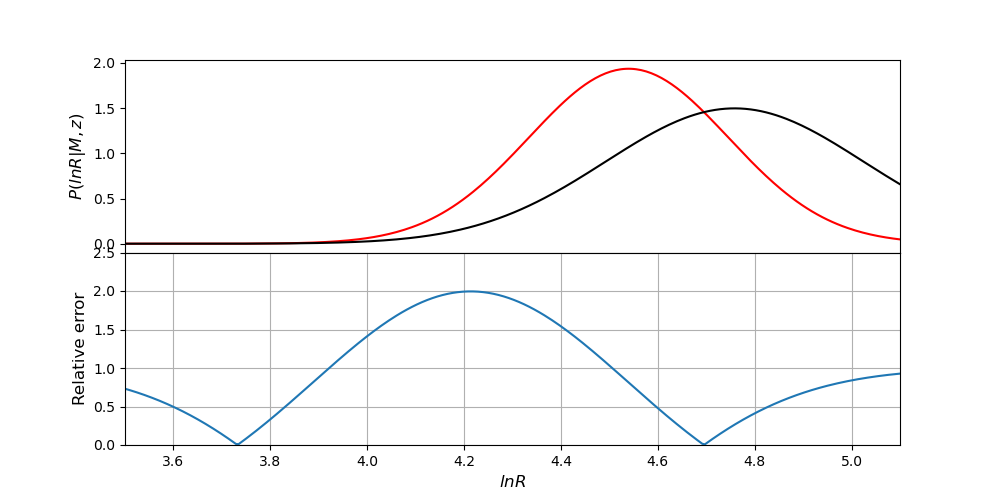

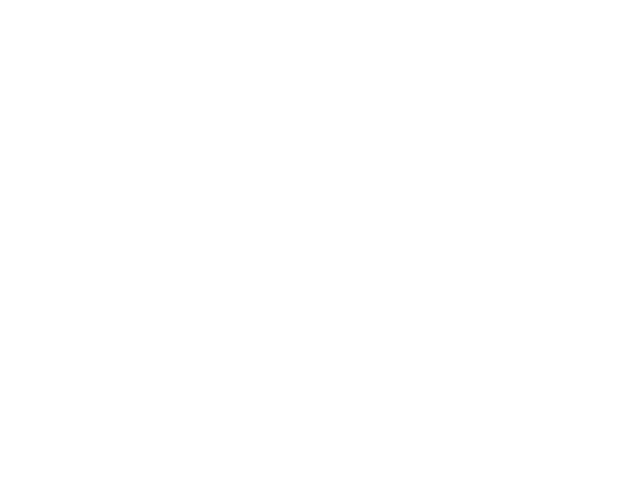

In [144]:
min_lnR = min(lnR)
max_lnR = max(lnR)
lnR_range = np.linspace(min_lnR, max_lnR, 1000)

ascaso_pdf= p(ascaso, 33.0, 1.5, lnR_range) 
ext_pdf= p(lnrich_ext, 33.0, 1.5, lnR_range) 

plt.figure()
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={"hspace": 0}, figsize=(10, 5))

axs[0].plot(lnR_range, ascaso_pdf, c='r')
axs[0].plot(lnR_range, ext_pdf, c='k')

axs[1].plot(lnR_range, (np.abs(ascaso_pdf - ext_pdf) / ext_pdf)) 

axs[1].set_xlabel(r"$lnR$", fontsize=12)
axs[0].set_ylabel(r"$P(lnR | M, z)$", fontsize=12)
axs[1].set_ylabel("Relative error", fontsize=12)
#axs[1].set_yscale('log')
axs[1].set_ylim(0.0, 2.5)
axs[1].set_xlim(3.5, 5.1)

axs[1].grid()

plt.show()
